A partir de la siguiente URL:

https://www.tensorflow.org/tutorials/keras/regression?hl=es-419

Realiza todos los pasos que se dan en este notebook leyendo todas las explicaciones con el objetivo de comprenderlo. 

### IMPORTS

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)



2.3.1


### DATA LOADING

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/Users/purbina/.keras/datasets/auto-mpg.data'

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### DATA CLEANING

In [4]:
dataset.isna().sum()
dataset = dataset.dropna()

In [5]:
origin = dataset.pop('Origin')

In [6]:

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### DATA SPLIT (TRAINING y TEST)

In [7]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [8]:
train_dataset.shape , test_dataset.shape

((314, 10), (78, 10))

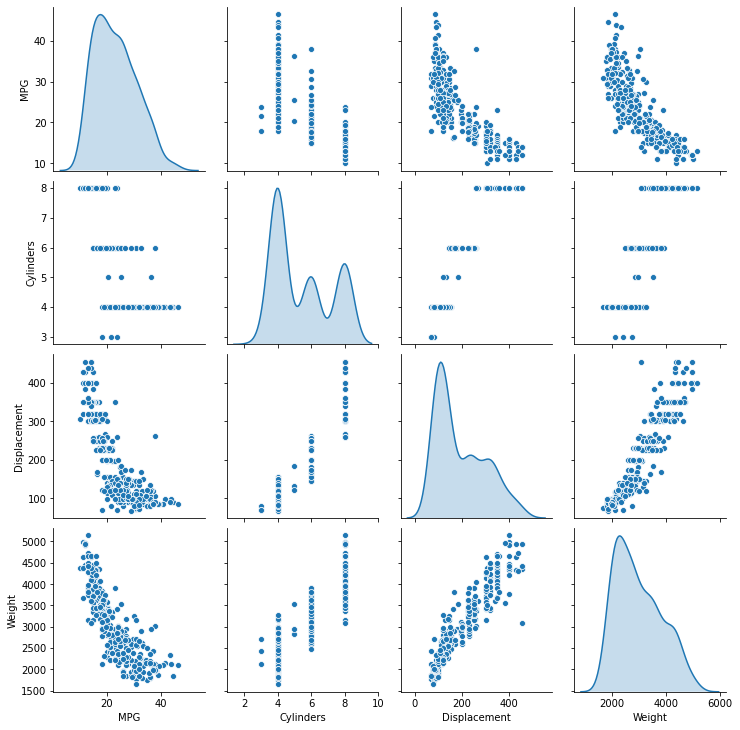

In [8]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [9]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [10]:
# MPG  = Variable a predecir (target)
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [11]:
# Normalización de la data de train y test . Esto es equivalente a lo que hace  Standard Scaler
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [12]:
normed_train_data.shape,  normed_test_data.shape

((314, 9), (78, 9))

In [13]:
normed_train_datas = normed_train_data.describe()
normed_train_datas = normed_train_data.transpose()
normed_train_datas

,146,282,69,378,331,257,310,328,125,108,...,171,70,307,49,209,281,229,150,145,182
Cylinders,-0.869348,-0.869348,1.483887,-0.869348,-0.869348,0.307270,-0.869348,-0.869348,0.307270,-0.869348,...,-0.869348,1.483887,0.307270,-0.869348,-0.869348,0.307270,1.483887,-0.869348,-0.869348,-0.869348
Displacement,-1.009459,-0.530218,1.482595,-0.865687,-0.942365,0.351586,-1.019044,-0.472709,0.025702,-0.942365,...,-0.587727,1.961837,-0.213919,-0.702745,-0.721914,0.044872,1.961837,-0.836932,-1.076553,-0.846517
Horsepower,-0.784052,-0.442811,1.447140,-1.099044,-0.994047,-0.390312,-1.177792,-0.994047,-0.259066,-0.442811,...,-0.232816,2.234620,0.265921,-0.495310,-0.442811,-0.521559,1.972127,-0.311564,-1.151543,-0.495310
Weight,-1.025303,-0.118796,1.736877,-1.025303,-1.001603,0.260397,-1.211344,0.307796,0.132419,-0.842816,...,-0.341571,1.696588,-0.343941,-0.912730,0.331495,-0.000298,1.457223,-0.710099,-1.169870,-0.623596
Acceleration,-0.379759,0.624102,-0.738281,-0.308055,0.875068,0.588250,1.161885,2.237451,0.337285,1.233589,...,-0.738281,-1.096803,-0.953394,-0.559020,2.273303,0.946772,-1.598734,-0.021237,1.233589,-0.021237
Model Year,-0.516397,0.843910,-1.060519,1.660094,1.115971,0.571849,1.115971,1.115971,-0.516397,-0.788458,...,-0.244335,-1.060519,0.843910,-1.332580,0.027726,0.843910,0.299787,-0.516397,-0.516397,0.027726
USA,0.774676,0.774676,0.774676,0.774676,-1.286751,0.774676,-1.286751,-1.286751,0.774676,-1.286751,...,-1.286751,0.774676,0.774676,0.774676,-1.286751,0.774676,0.774676,-1.286751,-1.286751,-1.286751
Europe,-0.465148,-0.465148,-0.465148,-0.465148,-0.465148,-0.465148,-0.465148,2.143005,-0.465148,-0.465148,...,-0.465148,-0.465148,-0.465148,-0.465148,2.143005,-0.465148,-0.465148,-0.465148,-0.465148,2.143005
Japan,-0.495225,-0.495225,-0.495225,-0.495225,2.012852,-0.495225,2.012852,-0.495225,-0.495225,2.012852,...,2.012852,-0.495225,-0.495225,-0.495225,-0.495225,-0.495225,-0.495225,2.012852,2.012852,-0.495225


In [68]:
normed_train_data.shape,  normed_test_data.shape


((314, 9), (78, 10))

NOTA: La normalización así como las codificaciones deben hacerse al conjunto de pruebas, así como los datos en vivo cuando el modelo se usa en producción.

### EL MODELO

In [14]:
# Dos Capas con 64 neuronas cada una. La capa de salida tiene un solo valor (corresponde al MPG a predecir)
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [15]:
model = build_model()

In [16]:
# Revisión del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Probar el modelo con un subconjunto de 10 datos del conjunto de entrenamiento
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.02844759],
       [ 0.01719376],
       [ 0.06772748],
       [-0.08745775],
       [-0.23043865],
       [ 0.05897729],
       [-0.23907042],
       [-0.00226361],
       [ 0.01765003],
       [-0.5434224 ]], dtype=float32)

In [ ]:
normed_train_data.shape  

ENTRENAMIENTO DEL MODELO CON 1000 EPOCHS

In [22]:
### Entrenamiento del modelo (1000 epochs). Se registra la precisión del modelo en el objeto history
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    print('ñ', end='')


In [23]:
# Display training progress by printing a single dot for each completed epoch

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

ññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññ

In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.825191,1.050919,2.825191,9.317385,2.300753,9.317385,995
996,2.895485,1.078370,2.895485,8.918643,2.256243,8.918643,996
997,2.807691,1.096081,2.807691,9.184336,2.258583,9.184336,997
998,2.937708,1.066921,2.937708,9.452342,2.325891,9.452342,998
999,3.013740,1.055527,3.013740,9.155001,2.283283,9.155001,999


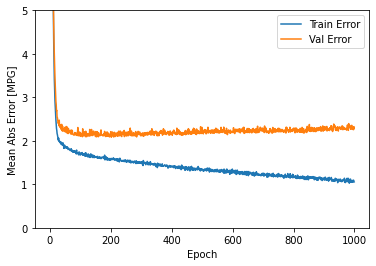

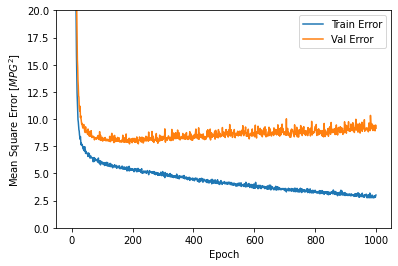

In [25]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

DEVOLUCION EARLY STOPPING

Este gráfico muestra poca mejora, o incluso degradación en el error de validación después de aproximadamente 100 épocas. Actualicemos la llamada `model.fit` para detener automáticamente el entrenamiento cuando el puntaje de validación no mejore. Utilizaremos una * devolución de llamada de EarlyStopping * que pruebe una condición de entrenamiento para cada época. Si transcurre una cantidad determinada de épocas sin mostrar mejoría, entonces detiene automáticamente el entrenamiento.

Puedes obtener más información sobre esta devolución de llamada [Aca](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).

ñññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññññ

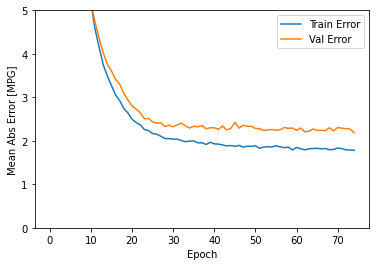

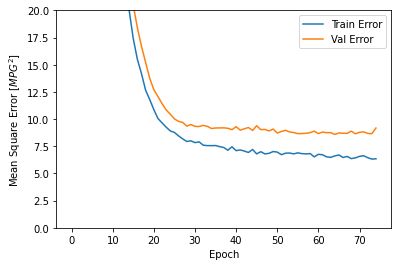

In [27]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [28]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.4856 - mae: 2.0391 - mse: 6.4856
Testing set Mean Abs Error:  2.04 MPG


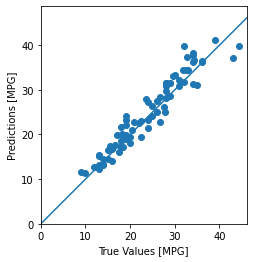

In [29]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

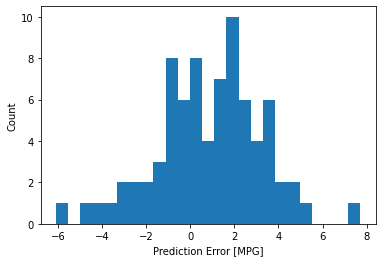

In [30]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

## Conclusion

Este cuaderno introdujo algunas técnicas para manejar un problema de regresión.

* El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión (se utilizan diferentes funciones de pérdida para problemas de clasificación).
* Del mismo modo, las métricas de evaluación utilizadas para la regresión difieren de la clasificación. Una métrica de regresión común es el error absoluto medio (MAE).
* Cuando las características de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.
* Si no hay muchos datos de entrenamiento, una técnica es preferir una red pequeña con pocas capas ocultas para evitar el sobreajuste.
* La detención temprana (EARLY STOP) es una técnica útil para evitar el sobreajuste.